In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.068 s)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [6]:
def plot_histogram(df, name):
    # Most common unit
    unit = df.groupby('unit').nunique().value.sort_values(ascending=False).index[0]
    avg = df.value.mean()
    stdev = df.value.std()

    fig, ax = plt.subplots()
    df.hist('value', bins=20, label=f'Total: {df.shape[0]:,}', ax=ax)
    ax.legend()
    ax.set(xlabel=f'{name} ({unit})', ylabel='count',
           title=f'Extracted {name} data\nMean = {avg:0.2f}, St. dev. = {stdev:0.2f}')
    plt.savefig(f'notebooks/hist.{name.replace(" ", "_")}.png', dpi=300)
    plt.show()

In [7]:
def plot_scatter(df, name):
    # sort 
    df = df.sort_values('value')

    # Most common unit
    unit = df.groupby('unit').nunique().value.sort_values(ascending=False).index[0]
    avg = df.value.mean()
    stdev = df.value.std()

    fig, ax = plt.subplots()
    ax.plot(range(df.shape[0]), df.value, 'ko', label=f'Total: {df.shape[0]:,}')
    ax.legend()
    ax.grid()
    ax.set(ylabel=f'{name} ({unit})', xlabel='serial',
           title=f'Extracted {name} data\nMean = {avg:0.2f}, St. dev. = {stdev:0.2f}')
    plt.savefig(f'notebooks/scatter.{name.replace(" ", "_")}.png', dpi=300)
    plt.show()

In [8]:
prop_list = [
    "tg",
    "bandgap",
    "sd",
    "hardness",
    "td",
    "co2_perm",
    "cs",
    "ct",
    "eab",
    "fs",
    "h2_perm",
    "iec",
    "is",
    "lcst",
    "loi",
    "meoh_perm",
    "o2_perm",
    "ri",
    "tm",
    "ts",
    "ucst",
    "wca",
    "wu",
    "tc",
    "ym",
]

len(prop_list)

25

tg 

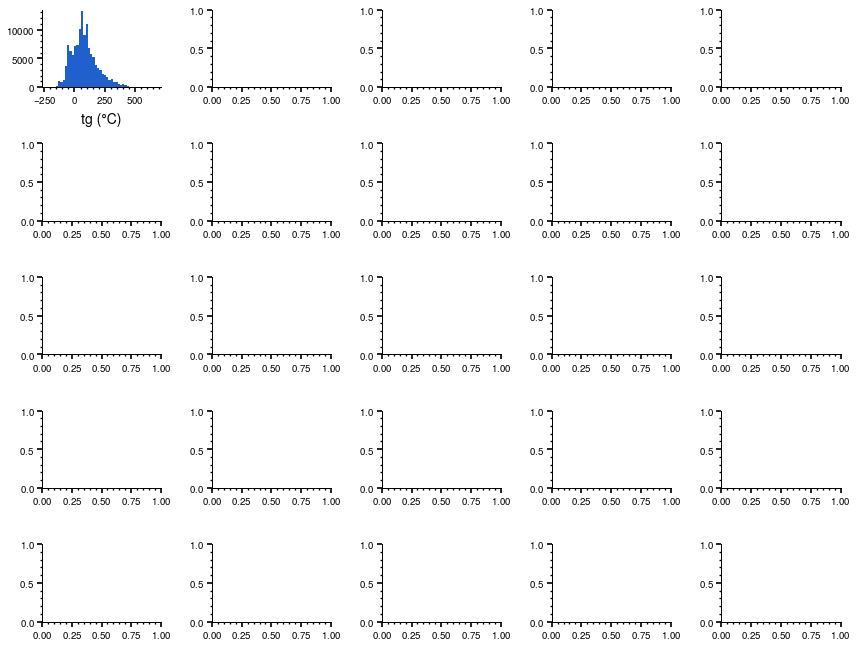

In [9]:
fig, axes = plt.subplots(5, 5, figsize=(7.25, 5.5), dpi=120)
axes = axes.flatten()

for i, prop in enumerate(prop_list):
    print(prop, end = ' ')
    meta = execute("""
        Select name, stdunit, scale
        From property_metadata
        Where property = :prop;
    """, prop = prop)
    
    df = execute("""
        Select value From extracted_data
        Where   property = :prop
        And     method = :method;
    """, prop = prop, method = 'GPT-3.5')

    ax = axes[i]
    ax.set(xlabel=f'{prop} ({meta.stdunit[0]})')

    if df is None:
        continue
    ax.hist(df.value, bins=50)

    break

plt.tight_layout()
# plt.savefig(f'notebooks/hist.all.png', dpi=300)
plt.show()

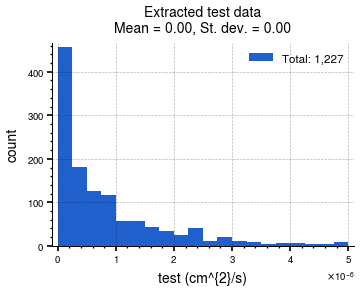

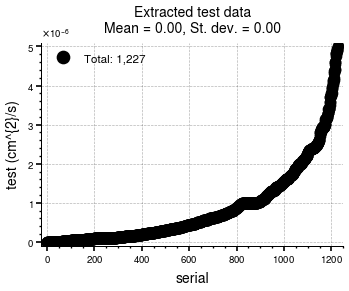

In [10]:
df0 = execute("""
    SELECT * FROM extracted_data
    WHERE property = 'meoh_perm'
    AND method = 'GPT-3.5'
    -- AND confidence = 1  -- polymer only
""")
plot_histogram(df0, 'test')
plot_scatter(df0, 'test')
# df0.sort_values('value')

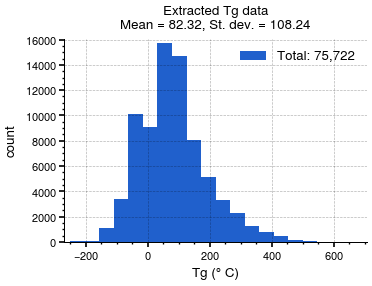

In [13]:
df1 = execute("""
    SELECT * FROM extracted_data
    WHERE property = 'tg'
    AND method = 'MaterialsBERT'
    --AND confidence = 1  -- polymer only
""")
plot_histogram(df1, 'Tg')
# df.sort_values('value')


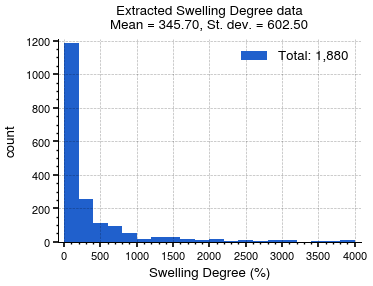

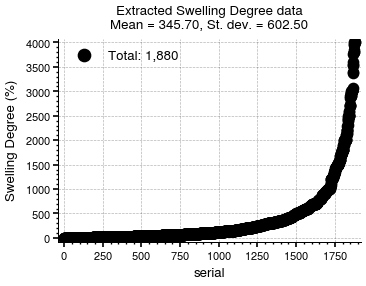

,property_id,method,material,property,value,unit,doi,confidence,id,date_added
1126,3744621,GPT-3.5,hydrogel,sd,0.0,%,10.1016/j.ijpharm.2019.118648,0,176418,2023-11-08 23:56:19.938962-05:00
126,3742237,GPT-3.5,APSi capsules,sd,0.0,%,10.1021/cm701959e,0,175413,2023-11-08 23:56:19.938962-05:00
243,3742616,GPT-3.5,PSF-b-PEG,sd,0.0,%,10.1016/j.memsci.2018.04.021,0,175532,2023-11-08 23:56:19.938962-05:00
342,3742900,GPT-3.5,poly (acrylic acid-co-acrylamide)/Kaol,sd,0.0,%,10.1016/j.clay.2014.11.009,1,175631,2023-11-08 23:56:19.938962-05:00
365,3742948,GPT-3.5,polysulfone,sd,0.0,%,10.1016/j.seppur.2019.05.013,1,175654,2023-11-08 23:56:19.938962-05:00
...,...,...,...,...,...,...,...,...,...,...
870,3744031,GPT-3.5,[2 + 4]P,sd,3940.0,%,10.1039/c9py01878f,0,176161,2023-11-08 23:56:19.938962-05:00
746,3743742,GPT-3.5,C0,sd,3977.0,%,10.1016/j.ijbiomac.2020.01.058,0,176037,2023-11-08 23:56:19.938962-05:00
1219,3744800,GPT-3.5,lyophilized cross-linked carboxymethyl chitin,sd,4000.0,%,10.1016/j.carbpol.2017.05.023,0,176511,2023-11-08 23:56:19.938962-05:00
1201,3744769,GPT-3.5,PNIPAM conjugates,sd,4000.0,%,10.1016/j.eurpolymj.2008.04.004,0,176493,2023-11-08 23:56:19.938962-05:00


In [23]:
df2 = execute("""
    SELECT * FROM extracted_data
    WHERE property = 'sd'
    -- AND confidence = 1  -- polymer only
""")
plot_histogram(df2, 'Swelling Degree')
plot_scatter(df2, 'Swelling Degree')
df2.sort_values('value')